# Email spam classification

   - The data contains 3 subfolders:
      - `ham` contains ham emails.
      - `spam` contains spam emails.
      - `testing` is a folder containing test emails for your classifier. The ham/spam label is in the filename.
      
**Important**: For this problem, we do *not* use neural nets/deep nets.

**(a) Printing the number of ham and spam emails**

   - Is this dataset imbalanced? Will this be problematic in training the model?
   - If so, how would you address it? 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import glob

#main folder path
main_folder_path = '/content/drive/MyDrive/Unstructured_Data_Analytics/HW3/email-data'

for subfolder in os.listdir(main_folder_path):
    subfolder_path = os.path.join(main_folder_path, subfolder)

    if os.path.isdir(subfolder_path):
        files = glob.glob(os.path.join(subfolder_path, '*'))
        file_count = len(files)

        print(f'Total files in "{subfolder}": {file_count}')

Total files in "spam": 3671
Total files in "ham": 1500
Total files in "testing": 100


**answers to the above questions:**

Yes, this dataset is imbalanced. In our case, with 1500 ham emails and 3671 spam emails, the spam class is more than twice the size of the ham class. This imbalance can potentially lead to issues in training a machine learning model.

Strategies to Address Imbalance:
Resampling Techniques:

Oversampling the Minority Class: Increase the number of samples in the minority class (ham) by replicating them or using techniques like SMOTE (Synthetic Minority Over-sampling Technique).
Undersampling the Majority Class: Reduce the number of samples in the majority class (spam) to balance the dataset.
Altering Class Weights:

Use algorithms that support class weighting, giving more weight to the minority class during training. Many models in scikit-learn have a class_weight parameter that can be set to 'balanced' or manually specified weights.



**(b) Construct the documents**

   - Provided below is a function that returns a document present in a file given a filename.
   - The function performs some preprocessing to (1) remove punctuation, (2),(3) remove whitespace and (4) lowercase all words.
   - We use this function to construct a list of documents.
   - Also construct a list of document labels containing `1` for spam and `0` for ham.

In [5]:
import re
import string
import codecs

def make_word_list(path):

    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()

    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)

    text = re.sub(r'\S*\d\S*','',corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]','',text)         # -- (3)

    text = text.lower().split()           # -- (4)

    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [6]:
import os

folder_path = '/content/drive/MyDrive/Unstructured_Data_Analytics/HW3/email-data'

documents = []
labels = []

# Function to process files in a given subfolder
def process_files(subfolder, label):
    subfolder_path = os.path.join(folder_path, subfolder)
    for filename in os.listdir(subfolder_path):
        if filename.endswith('.txt'):
            file_path = os.path.join(subfolder_path, filename)
            document = make_word_list(file_path)
            documents.append(document)
            labels.append(label)

# Process ham files
process_files('ham', 0)

# Process spam files
process_files('spam', 1)

**(c) Construct the document matrix `X` as a matrix of word frequencies**

   - Now we use the `CountVectorizer` from scikit-learn.
   - Set `min_df=50`; this drops words that don't occur in at least 50 documents.
   - Set `stop_words="english"` and `max_df=0.8` to filter out stop-words.
   - Print the size of the vocabulary (number of unique words)

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=50, max_df=0.8, stop_words='english')

X = vectorizer.fit_transform(documents)

print(f"Size of vocabulary: {len(vectorizer.vocabulary_)}")

Size of vocabulary: 1680


**(d) k-NN: Hyperparameter selection**

Now that we have our documents and labels as training data, we can use a validation set to help select hyperparameters for a k-NN classifier.

We use the **weighted F1-score** as the evaluation metric (i.e., for the `f1_score` function imported from `sklearn.metrics`, be sure to use the parameter `average='weighted'`).

Provided is some seed code for hyperparameter tuning that you may modify and reuse.

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import numpy as np


# Assuming 'documents' and 'labels' are your data and target labels
X = X
y = labels

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a range of hyperparameters to test (e.g., different values of k)
hyperparameter_settings = [2, 4, 6, 8, 10, 12, 14, 16]

best_score = -np.inf
best_hyperparam_setting = None
best_model = None

# Iterate over the hyperparameter settings
for k in hyperparameter_settings:
    # Train the k-NN model
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)

    # Make predictions on the validation set
    y_pred = model.predict(X_val)

    # Calculate the weighted F1 score
    score = f1_score(y_val, y_pred, average='weighted')

    # Update the best score, hyperparameter and model if current model is better
    if score > best_score:
        best_score = score
        best_hyperparam_setting = k
        best_model = model

# Print the best hyperparameter setting and its score
print(f"Best F1 Score: {best_score}")
print(f"Best Hyperparameter (k): {best_hyperparam_setting}")

Best F1 Score: 0.9199959460829027
Best Hyperparameter (k): 2


**(e) Classifier testing: Precision-Recall and ROC curves**

We use test emails in the `testing` folder to **test** our best k-NN classifier (the one stored in `best_model` after running our code for part (d)) and construct the plots below.


   - We construct an ROC curve for a k-NN classifier. (We vary the threshold probability of declaring an email to be spam to obtain these plots.) In the legend of this plot, we display the AUC for the k-NN classifier.
   - We construct one plot containing a precision-recall curve for the k-NN classifier. In the legend of this plot, we display the average precision for each classifier using the sklearn function [`average_precision_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score); average precision is essentially an approximation of the area under the precision-recall curve that avoids being overly optimistic.

Note that these plots are on the test data: we will have to read in this data, construct a document matrix and labels. Some words in the test data may not have been present in the training data: there are multiple ways to address this, then we briefly describe our approach.

Things to answer:

   - Of the ROC and Precision-Recall curves, which one would you use for this task and why?

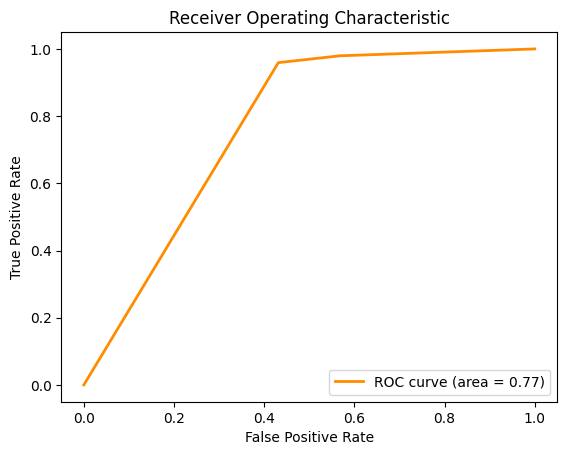

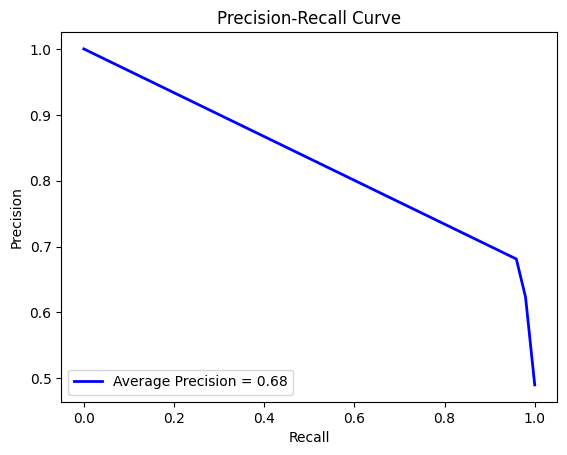

In [9]:
# Process files in the test dataset
import os

def process_test_files(folder_path):
    test_documents = []
    test_labels = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):

            if '.spam' in filename:
                label = 1  # Spam
            elif '.ham' in filename:
                label = 0  # Ham


            file_path = os.path.join(folder_path, filename)
            document = make_word_list(file_path)

            test_documents.append(document)
            test_labels.append(label)

    return test_documents, test_labels

# Path to the folder containing test emails

test_folder_path = '/content/drive/MyDrive/Unstructured_Data_Analytics/HW3/email-data/testing'

# Process the test files and get documents and labels
test_documents, test_labels = process_test_files(test_folder_path)



import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Transform the test data using the same vectorizer
X_test = vectorizer.transform(test_documents)
y_test = test_labels

# Use the best model to get the probability predictions
y_score = best_model.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_score)
average_precision = average_precision_score(y_test, y_score)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Average Precision = %0.2f' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()



When dealing with words in the test data that were not present in the training data, the key challenge is how to handle these unseen words during the model's prediction phase. There are a few approaches to address this issue. I use the "Ignore Unseen Approach"

Ignore Unseen Words:  When using CountVectorizer by default, they ignore words in the test set that were not present in the training set. This approach assumes that the impact of unseen words on the overall prediction is minimal, especially if the training set is large and representative enough.


**Answer to the non-coding question:**

ROC Curve is generally used when the classes are balanced and the costs of false positives and false negatives are similar. It shows the trade-off between sensitivity (True Positive Rate) and specificity (1 - False Positive Rate).

Precision-Recall Curve is more informative when dealing with imbalanced datasets, where the focus is more on the positive class (spam in your case). It shows the trade-off between precision and recall for different threshold settings.

For spam detection, where false negatives (marking spam as ham) and false positives (marking ham as spam) might have different implications and the dataset might be imbalanced (typically more ham than spam), the Precision-Recall Curve is often more appropriate. It provides a better measure of success in predicting the positive class (spam) when the classes are imbalanced.